This report analyzes crime rates in San Francisco (SF) and Raleigh for the years 2005 to 2016. In particular, we analyze spatial and temporal trends for Homicide and Grand Theft Auto (GTA). We show timeseries of the frequency of incident occurence and maps of their location, when available. Publically available civic data for SF and Raleigh were obtained from [here](https://data.sfgov.org/api/views/gxxq-x39z/rows.csv?accessType=DOWNLOAD) and [here](https://data.raleighnc.gov/api/views/csw9-dd5k/rows.csv?accessType=DOWNLOAD) respectively, and downloaded on 2/28/2016. Homicide data for SF was not available, and thus was omitted from the analysis.

Higher rates of GTA were found in SF than in Raleigh, which is expected because of greater population density.
The geospatial distribution of GTA incidents were found to be distributed evenly over each city. Murder incidents in Raleigh were found to tend towards the mid and Southern regions. 

Our preliminary results follow.

In [27]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
from IPython.core.pylabtools import figsize
from IPython.display import Image
warnings.filterwarnings('ignore')

### Get data

if not os.path.exists('./data'):
    os.mkdir('./data')

# Get SF crime data
if not os.path.exists('./data/sf_data.csv'):
    !wget -O ./data/sf_data.csv https://data.sfgov.org/api/views/gxxq-x39z/rows.csv?accessType=DOWNLOAD

# Get Raleigh crime data
if not os.path.exists('./data/raleigh_data.csv'):
    !wget -O ./data/raleigh_data.csv https://data.raleighnc.gov/api/views/csw9-dd5k/rows.csv?accessType=DOWNLOAD

df_sf = pd.read_csv('./data/sf_data.csv')
df_ra = pd.read_csv('./data/raleigh_data.csv')
sf_cats = df_sf['Category'].unique()
ra_cats = df_ra['LCR DESC'].unique()

sf_gta_cats = ['VEHICLE THEFT']
sf_murder_cats = None
ra_gta_cats = ['Larceny/Theft from Motor Vehicle', 
               'MV THEFT/OTHER VEHICLES', 
               'MV THEFT/AUTOMOBILE', 
               'MV THEFT/TRUCK OR BUS']

ra_murder_cats = ['Homicide/Murder-Nonnegligent Manslaughter', 
                  'MURDER AND NONNEGLIGENT MANSLAUGHTER', 
                  'MURDER/MANSLAUGHTER BY NEGLIGENCE']

def subset_dataframe_inds(df, cats, on):
    if cats:
        inds = (df[on] == x for x in cats)
        X = sum(inds)
        return df[X == 1]
    
def parse_date(x):
    date = x['Date']
    time = x['Time']
    hour, minute = time.split(":")
    dt = datetime.datetime.strptime(date, fmt)
    dt = dt.replace(hour=int(hour), minute=int(minute))
    return dt
    

def create_time_var(df, time_var, fmt):
    return df[time_var].apply(lambda x: datetime.datetime.strptime(x, fmt))

df_ra_gta = subset_dataframe_inds(df_ra, ra_gta_cats, 'LCR DESC')
df_ra_murder = subset_dataframe_inds(df_ra, ra_murder_cats, 'LCR DESC')
df_sf_gta = subset_dataframe_inds(df_sf, sf_gta_cats, 'Category')
df_sf_murder = subset_dataframe_inds(df_sf, sf_murder_cats, 'Category')

fmt = '%m/%d/%Y %I:%M:%S %p'
df_ra_gta['time'] = create_time_var(df_ra_gta, 'INC DATETIME', fmt)
df_ra_murder['time'] = create_time_var(df_ra_murder, 'INC DATETIME', fmt)
df_sf_gta['time'] = df_sf_gta.apply(parse_date, axis=1)
#df_sf_murder['time'] = df_sf_murder.apply(parse_date, axis=1)

def create_ts(df, freq):
    N = len(df)
    ones = np.ones(N)
    ts = pd.Series(data=ones, index=df.time)
    tss = ts.resample(freq, how="sum")
    tss = tss.fillna(0)
    return tss

#Merge time series
ts_ra_gta = create_ts(df_ra_gta, "1D")
ts_sf_gta = create_ts(df_sf_gta, "1D")
#Span is size of window
ts_ra_gta_ewma = pd.ewma(ts_ra_gta, span=20)
ts_sf_gta_ewma = pd.ewma(ts_sf_gta, span=20)
df_ra_gta_ts = pd.DataFrame( {'Raleigh': ts_ra_gta, 
                              'Raleigh Smooth': ts_ra_gta_ewma})
df_sf_gta_ts = pd.DataFrame( {'SF': ts_sf_gta,
                              'SF Smooth': ts_sf_gta_ewma})
df_gta_ts = pd.merge(df_ra_gta_ts, df_sf_gta_ts, left_index=True, right_index=True)

min_year = df_gta_ts.index.min().year
max_year = df_gta_ts.index.max().year

# Time series of Grand Theft Auto Incidents

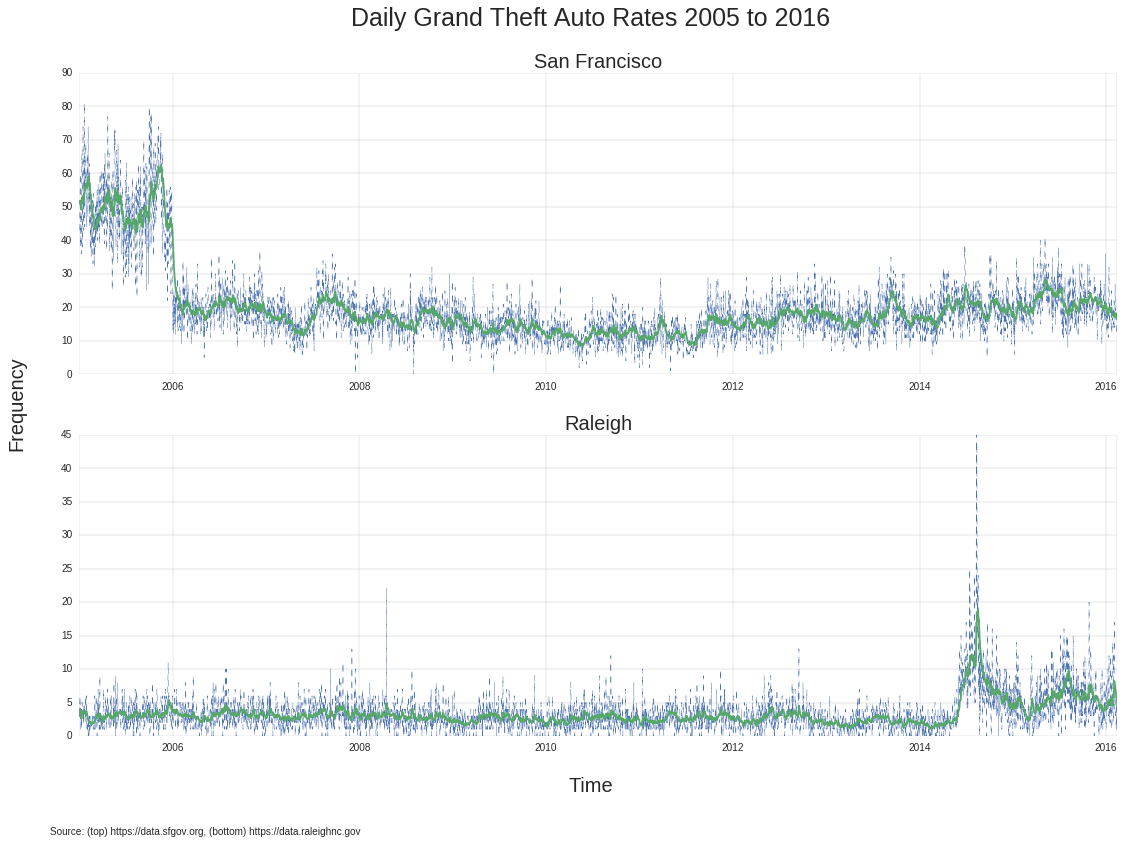

In [28]:
#Plot
fig, axes = plt.subplots(nrows=2, ncols=1, #sharex=True, #sharey=True, 
                         figsize=(15, 10))

fig.text(0.5, -0.04, 'Time', ha='center', fontsize=20)
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)


grid_lw = 0.2
ax1 = axes[0]
ax1.set_axis_bgcolor('white')
ax1.grid(which='major', color='grey', lw=grid_lw) 
ax1.grid(which='minor', color='white', lw=grid_lw) 

df_gta_ts['SF'].plot(style='--', lw=0.5, ax=ax1)
df_gta_ts['SF Smooth'].plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_title('San Francisco', fontsize=20)

ax2 = axes[1]
ax2.set_axis_bgcolor('white')
ax2.grid(which='major', color='grey', lw=grid_lw) 
ax2.grid(which='minor', color='white', lw=grid_lw)
df_gta_ts['Raleigh'].plot(style='--', lw=0.5, ax=ax2)
df_gta_ts['Raleigh Smooth'].plot(ax=ax2)
ax2.set_xlabel('')
ax2.set_title('Raleigh', fontsize=20)

suptitle = 'Daily Grand Theft Auto Rates {0} to {1}'.format(min_year, max_year)
plt.suptitle(suptitle, x=0.5, y=1.05, fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)

plt.figtext(0, -0.1, '''Source: (top) https://data.sfgov.org, (bottom) https://data.raleighnc.gov''')
#plt.figtext(0, -0.1, '''Source: (top) https://data.sfgov.org \n             (bottom) https://data.raleighnc.gov''')

The data was resampled to daily frequency. The green line is an exponentially weighted moving average $\footnote{http://pandas.pydata.org/pandas-docs/stable/computation.html\#exponentially-weighted-moment-functions}$ added to assist visualization. A few observations:

* There are clear breakpoints in each timeseries. One occurs for SF in 2006 and one for Raleigh in mid-2014.
* GTAs occur more frequency in SF than in Raleigh, and with greater volatility. 
* Raleigh has a lower rate of GTAs. An anomalous spike exists in late 2014.

The source of the breakpoints, whether they be due to a real change in crime or a recoding of the data, is undetermined at this time. Additional facts about the trends follow:

In [77]:
print("The mean for SF before 2006 was {0:.3} GTA incidents per day."\
      .format(df_gta_ts['SF'][df_gta_ts.index > datetime.datetime.strptime('2006', '%Y')].mean()))
print("The mean for SF after 2006 was {0:.3} GTA incidents per day.".\
      format(df_gta_ts['SF'][df_gta_ts.index <= datetime.datetime.strptime('2006', '%Y')].mean()))

anom = df_gta_ts.Raleigh.argmax()
print("The anomalous spike for Raleigh occurs on {0}.".format(anom.date()))
ra_bp_date = datetime.datetime.strptime('2014-06', '%Y-%m')

print("The mean for Raleigh before {0} was {1:.3} GTA incidents per day."\
      .format(ra_bp_date, df_gta_ts['Raleigh'][df_gta_ts.index > ra_bp_date].mean()))
print("The mean for Raleigh after {0} was {1:.3} GTA incidents per day.".\
      format(ra_bp_date, df_gta_ts['Raleigh'][df_gta_ts.index <= ra_bp_date].mean()))


The mean for SF before 2006 was 16.9 GTA incidents per day.
The mean for SF after 2006 was 49.8 GTA incidents per day.
The anomalous spike for Raleigh occurs on 2014-08-11.
The mean for Raleigh before 2014-06-01 00:00:00 was 6.44 GTA incidents per day.
The mean for Raleigh after 2014-06-01 00:00:00 was 2.75 GTA incidents per day.


## Time series of Murder Incidents

The following data pertains to Raleigh only.

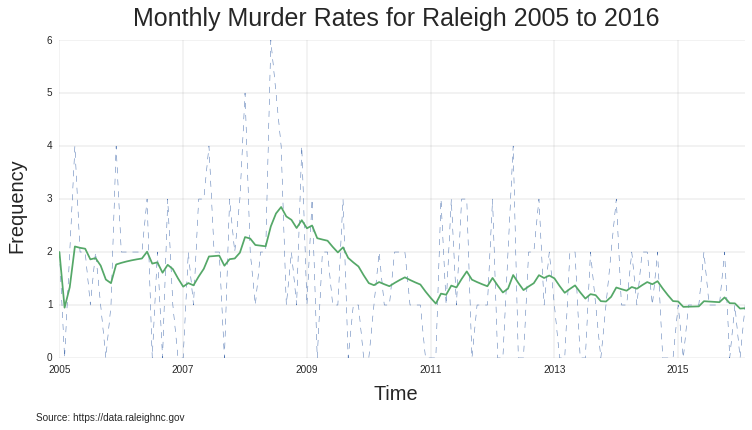

In [29]:
#Merge time series
ts_ra_murder = create_ts(df_ra_murder, "1M")

#Span is size of window
ts_ra_murder_ewma = pd.ewma(ts_ra_murder, span=20)
df_ra_murder_ts = pd.DataFrame( {'Raleigh': ts_ra_murder, 
                              'Raleigh Smooth': ts_ra_murder_ewma})

min_year = df_gta_ts.index.min().year
max_year = df_gta_ts.index.max().year

#Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

fig.text(0.5, -0.04, 'Time', ha='center', fontsize=20)
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)


grid_lw = 0.2
ax1 = axes
ax1.set_axis_bgcolor('white')
ax1.grid(which='major', color='grey', lw=grid_lw) 
ax1.grid(which='minor', color='white', lw=grid_lw) 

df_ra_murder_ts['Raleigh'].plot(style='--', lw=0.5, ax=ax1)
df_ra_murder_ts['Raleigh Smooth'].plot(ax=ax1)
ax1.set_xlabel('')
#ax1.set_title('Raleigh', fontsize=20)

suptitle = 'Monthly Murder Rates for Raleigh {0} to {1}'.format(min_year, max_year)
plt.suptitle(suptitle, x=0.5, y=1.05, fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)

plt.figtext(0, -0.1, '''Source: https://data.raleighnc.gov''')

The data was resampled to monthly frequency due to sparsity. The trend is overall decreasing for Raleigh, with an increase in 2007-2009. No breakpoints are observed.

In [80]:
print("The mean for Raleigh was {0:.3} homicide incidents per day."\
      .format(df_ra_murder_ts.Raleigh.mean()))

The mean for Raleigh was 1.52 homicide incidents per day.


We now turn to spatial patterns in the data.

## Spatial Analysis

We pool each crime observation from all years for each cities. Then, we plot each incident with a recorded latitude and longitude. The data was sampled to 10% to alleviate computational burden in producing the graphic. Homicides is coded as blue. Murder is coded as red.

### Map for SF GTA

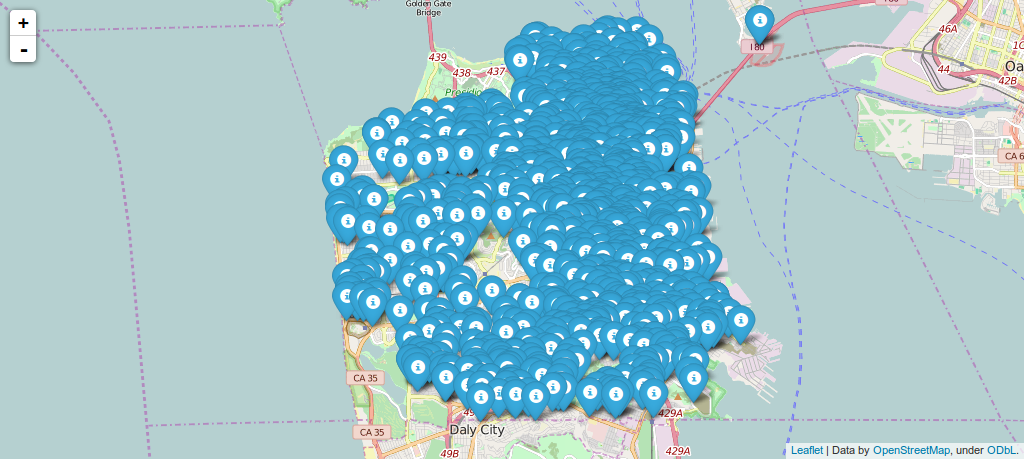

In [30]:
Image('./sf_gta.png')

(Source: https://data.raleighnc.gov). The map suggests that GTA incidents are distributed evenly throughout SF.

### Map for Raleigh GTA

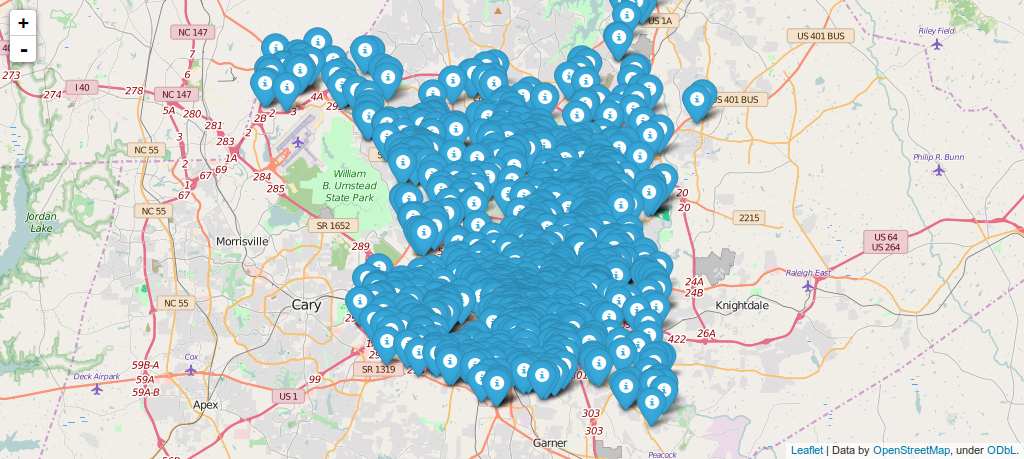

In [31]:
Image('./raleigh_gta.png')

(Source: https://data.raleighnc.gov). The map suggests that GTA incidents are distributed evenly throughout Raleigh.

### Map for Raleigh Murder

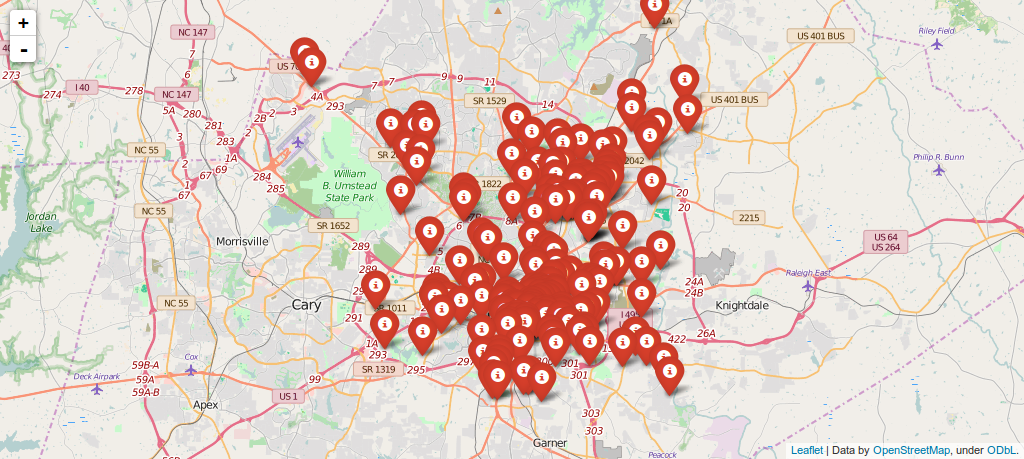

In [32]:
Image('./raleigh_murder.png')

(Source: https://data.raleighnc.gov). The map suggests that murder incidents occur primarily in mid to South Raleigh, with fewer occurring in North Raleigh.

## Preprocessing

##### Definitions of GTA and Homicide

The data for SF and Raleigh contain lists of crime categories. To carry through the analysis, we must define what categories comprise GTA and murder. SF had 39 categories, and Raleigh 435. These lists were small enough to manually inspect. Note that GTA is it's own category of theft, due to high volume $\footnote{https://www.justia.com/criminal/docs/uniform-crime-reporting-handbook/larceny-theft.html}$. Thus, we can reliabily extract that signal. The following crimes categories were identified:

* SF:
    * GTA: 'VEHICLE THEFT'
    * Murder: None

* Raleigh:
    * GTA: 'Larceny/Theft from Motor Vehicle', 'MV THEFT/OTHER VEHICLES', 'MV THEFT/AUTOMOBILE', 'MV THEFT/TRUCK OR BUS'
    * Murder: 'Homicide/Murder-Nonnegligent Manslaughter', 'MURDER AND NONNEGLIGENT MANSLAUGHTER','MURDER/MANSLAUGHTER BY NEGLIGENCE'

### Data Quality

The data comes from a government source and thus we can have confidence in its integrity. However, the omission of homicides from the San Francisco data is concerning. This may indicate an intentional omission of data.

### Future Work
A more detailed analysis could precisely identify the breakpoints in the time series. 

### Appendix
See `vrr-assignment-04-appendix` for the code used to perform this analysis.